In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from flax.linen.activation import softmax
from einops import rearrange
from jax import random
from jax.example_libraries import optimizers
import optax
import sys

In [2]:
# MHSA attention layer
class Attention(nn.Module):

    scale_exp: jnp.float32
    dim: int
    heads: int
    
    def setup(self):
        
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
        # computes key, query, value
        self.qkv_layer = nn.Dense(features = 3*self.heads * self.dim, kernel_init = kif)
        return
    
    def __call__(self,inputs):
        
        qkv = self.qkv_layer(inputs) / jnp.sqrt( inputs.shape[-1] ) # (batch, loc, 3*h*d)
        qkv = rearrange( qkv, 'b l (h d) -> b h l d' , h = self.heads) # (batch, heads, loc, d )
        q,k,v = jnp.split(qkv, 3, axis = -1) # gives q, k, v each of shape ( batch, heads, loc, d )       
        A = 1.0/ self.dim**(self.scale_exp) * jnp.einsum('ijkl,ijml->ijkm', q, k) # batch x heads x loc x loc
        phi_A = softmax( A, axis=-1 )
        out = jnp.einsum('ijkl,ijlm->ijkm', phi_A, v) # (batch, head, loc, d)  
        out = rearrange(out, 'b h l d -> b l (h d)')
        return out


class VIT(nn.Module):
    """A simple VIT model"""
  
    dim: int
    heads: int
    depth: int
    patch_size: int
  
    @nn.compact
    def __call__(self, x, train = True):
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
        N = self.heads * self.dim
        D = 3
        
        # patchify images
        x = rearrange(x, 'b (w p1) (h p2) c -> b (w h) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size) # (batch, loc, patch_ch_dim )
        
        x = nn.Dense(features = N, kernel_init = kif)(x) / jnp.sqrt( 3 * self.patch_size**2 )
        x = nn.relu(x)
        for l in range(self.depth):
            h = nn.LayerNorm()(x)
            x = x + 1/jnp.sqrt(self.depth) * Attention(dim = self.dim, scale_exp = 1.0, heads = self.heads)(h)
            h = nn.LayerNorm()(x)
            h = nn.Dense(features = N, kernel_init = kif)(h) / jnp.sqrt(N)
            h = nn.relu(h)
            x = x + 1/jnp.sqrt(self.depth)* nn.Dense(features = N, kernel_init = kif)(h) / jnp.sqrt(N)  
        
        # pool over location index
        x = nn.LayerNorm()(x)
        x = x.mean(axis = 1) # (batch, N)
        x = nn.Dense(features = 10, use_bias = False, kernel_init = kif)(x) / jnp.sqrt(self.dim**2 * self.heads)  # for mean field scaling
        return x

In [88]:
dim = 128
heads = 4
depth = 10
patch_size = 4
model = VIT(dim = dim, heads = heads, depth = depth, patch_size = patch_size)

In [91]:
params = model.init(random.PRNGKey(0), jnp.ones((4,32,32,3)) ) 

out = model.apply(params, X[0:50])
print(out.shape)

(50, 10)


In [3]:
import numpy as np

data_dir = '/n/holyscratch01/pehlevan_lab/Everyone/cifar-5m-new'
file_name = f"{data_dir}/cifar5m_part{0}.npz"
part0 = np.load(file_name, allow_pickle=True)
X0, y0 = np.load(file_name, allow_pickle=True)

arr = [part0[k] for k in part0.keys()]
X = arr[0]
y = arr[1]
print(y.shape)
print(X.shape)

(1000448,)
(1000448, 32, 32, 3)


In [4]:

X = X - X.mean()
X = X / X.std()


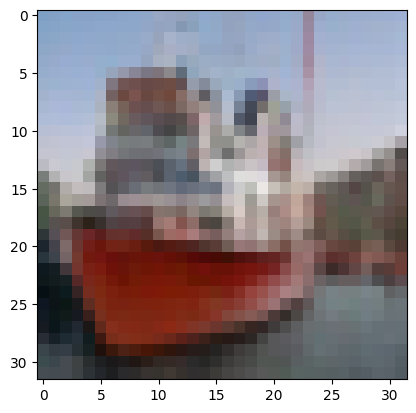

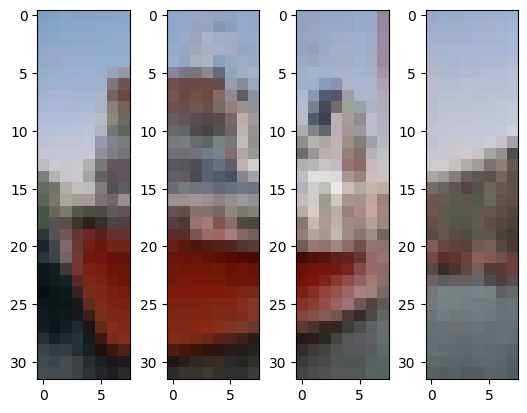

(4, 32, 8, 3)
(2, 4, 8, 16, 3)


In [93]:
x = X[0]

X = X - X.mean()
X = X / X.std()

plt.imshow(x)
plt.show()

new_split = jnp.split(x, 4, axis = 1 ) # patch x dim x (patch'*dim) x c 

plt.figure()
for i, split in enumerate(new_split):
    plt.subplot(1,4,i+1)
    plt.imshow(split)
plt.show()

print(jnp.array(new_split).shape) 
split_arr = jnp.array(new_split).transpose((0,2,1,3) ) # patch x dim x (patch' * dim') x channel

split_final = jnp.array( jnp.split(split_arr, 2, axis = 2) ) # patch' x patch x dim x dim' x channel
print(split_final.shape)


(4, 4, 8, 8, 3)


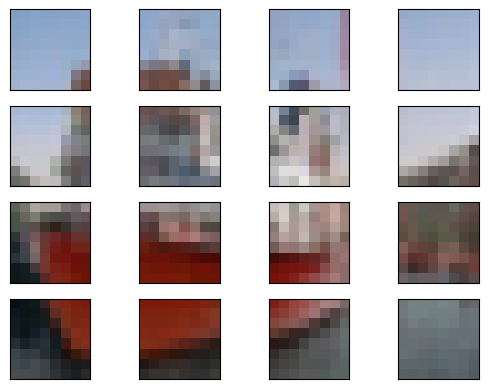

In [59]:
x_re = rearrange(x, '(a p1) (b p2) c -> a b p1 p2 c', p1 = 8, p2 = 8)
print(x_re.shape)

plt.figure()
for a in range(4):
    for b in range(4):
        plt.subplot(4,4,4*a+b+1)
        plt.imshow(x_re[a,b,:,:,:])
        plt.xticks([])
        plt.yticks([])
plt.show()

## Train VIT on CIFAR-5M

In [32]:
dim = 128
heads = 4
depth = 3
patch_size = 4


T = 5000
batch = 128

gamma = 0.3
lr = 1.5

def train_model(param_args, opt_args):

    dim, heads, depth, patch_size = param_args
    T, batch, gamma, lr = opt_args
    model = VIT(dim = dim, heads = heads, depth = depth, patch_size = patch_size)

    opt_init, opt_update, get_params = optimizers.sgd( dim * gamma**2 *  lr )
    params = model.init(random.PRNGKey(0), jnp.ones((4,32,32,3)) )['params']
                                                               
    opt_state = opt_init(params)

    shift_fn = jax.jit(lambda p, x: (model.apply({'params':p}, x) - model.apply({'params':params}, x)) / gamma)
    loss_fn = jax.jit(lambda params, Xb, yb: optax.softmax_cross_entropy_with_integer_labels(logits=shift_fn(params, Xb), labels=yb).mean())
    grad_fn = jax.jit(jax.grad(loss_fn))


    losses = []
    
    loss_t = 0.0
    for t in range(T):
    
        if t*batch > X.shape[0]:
            break
        
        ind = (t*batch) % X.shape[0]
        Xt = X[t*batch:(t+1)*batch]
        yt = y[t*batch:(t+1)*batch]
    
        loss_t = loss_t * t/(t+1) + 1.0/(t+1) * loss_fn(get_params(opt_state), Xt, yt)
    
        losses += [loss_t]
        sys.stdout.write(f'\r loss = {loss_t}')
        opt_state = opt_update(t,grad_fn(get_params(opt_state), Xt, yt),opt_state)
        
    return losses

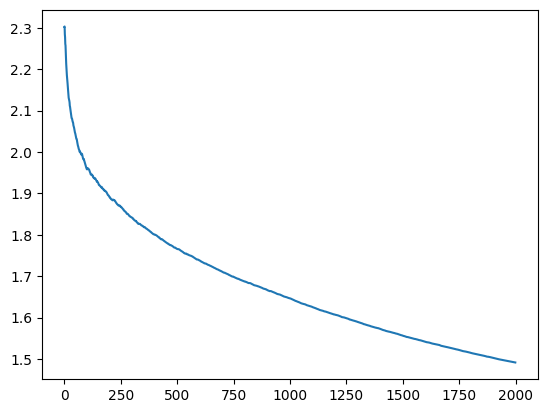

In [33]:
plt.plot(losses)
plt.show()

In [45]:
dimvals = [16,32,64,128, 256]
depth = 2
heads = 3

T = 7500
lr = 2.5

opt_args = ( T, batch, gamma, lr )

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size)
    print(" ")
    print(f"dim = {dim}")
    losses = train_model(param_args, opt_args)
    all_losses += [losses] 

 
dim = 16
 loss = 1.3097045421600342 
dim = 32
 loss = 1.2611745595932007 
dim = 64
 loss = 1.2172863483428955 
dim = 128
 loss = 1.1841892004013062 
dim = 256
 loss = 1.1800379753112793

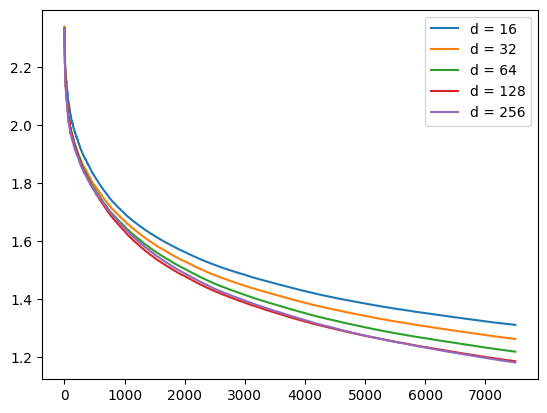

In [46]:
for i, loss in enumerate(all_losses):
    plt.plot(loss, label = f'd = {dimvals[i]}')
plt.legend()
plt.show()